# 0. 패키지 불러오기 

In [7]:
# 데이터 구성:Series,DataFrame
import pandas as pd

# 행렬 연산 패키지 
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

# scaling 
from sklearn.preprocessing import StandardScaler

# 데이터 분할:train,test
from sklearn.model_selection import train_test_split

# 로지스틱 회귀
from statsmodels.api import Logit

# 평가함수
from sklearn.metrics import accuracy_score

# confusion matrix
from sklearn.metrics import confusion_matrix

# 한글 깨짐 방지
import matplotlib.font_manager as fm 
font_list=[font.name for font in fm.fontManager.ttflist]
font_list
plt.rcParams['font.family']='NanumBarunGothic'

In [1]:
# 다중 공선성은 고민하지 말고 변수 선택은 고민 

# 1. 데이터 불러오기 

In [9]:
df_raw=pd.read_csv("/home/piai/Downloads/데이터_1/HMEQ.csv", engine='python')
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


# 2. 데이터 전처리 - 결측치 처리 

In [10]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [11]:
df_raw["JOB"].fillna("Other", inplace=True)
df_raw.fillna(df_raw.mean(), inplace=True)

In [12]:
# 데이터 분할 
df_train,df_test=train_test_split(df_raw, test_size=0.3,random_state=1234)
print('train data size:{}'.format(df_train.shape))
print('test data size:{}'.format(df_test.shape))

train data size:(2623, 13)
test data size:(1125, 13)


# 3. 모델 및 회귀계수 검토 

In [13]:
log_model=Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ + DEROG\
                            + DELINQ + CLAGE + NINQ + CLNO + DEBTINC""", df_train)
log_result=log_model.fit()
print(log_result.summary()) # Df Model: 입력변수의 개수 / Coef를 통해 분석한다. 

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Tue, 24 Nov 2020   Pseudo R-squ.:                  0.2257
Time:                        04:42:30   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

# 4. 예측 및 성능 평가

### 4-1 예측

In [14]:
y_pred=log_result.predict(df_test)
y_pred_class=(y_pred>0.5).astype(int)
y_pred_class.head()

1721    0
822     0
1686    0
789     0
165     0
dtype: int64

### 4-2 평가

In [15]:
print("Accuracy:{0:3f}\n".format(accuracy_score(df_test["BAD"],y_pred_class)))
print("Confusion Matrix:\n{}".format(confusion_matrix(df_test["BAD"],y_pred_class)))

Accuracy:0.924444

Confusion Matrix:
[[1017    4]
 [  81   23]]


# 5. 결론 도출 

### 5-1 결론 도출 - 최종 회귀식 

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


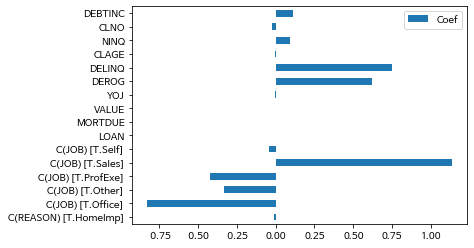

In [16]:
df_logistic_coef=pd.DataFrame({"Coef": log_result.params.values[1:]},index=log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

### 5-2 표준화 회귀 계수

In [18]:
# select_dtypes : 특정 변수 타입을 선택, 제외하여 데이터 추출
df_char=df_raw.select_dtypes(include="object")
df_numeric=df_raw.select_dtypes(exclude="object")

# Data Scaling
scaler=StandardScaler()
np_numeric_scaled=scaler.fit_transform(df_numeric)
df_numeric_scaled=pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

# 문자 데이터 + 숫자 데이터
df_scaled=pd.concat([df_numeric_scaled,df_char], axis=1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,3.140664,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,3.140664,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,-0.318404,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,3.140664,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,-0.318404,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [19]:
# BAD 데이터를 0과 1로 변환 
df_scaled["BAD"]=np.where(df_scaled["BAD"]>0,1,0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [20]:
# 데이터 분할 
df_scaled_train, df_scaled_test=train_test_split(df_scaled,test_size=0.3, random_state=1234)

In [24]:
# from_formula 함수를 이용하여 변수 역할 지정 
scaled_log_model=Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ + DEROG\
                            + DELINQ + CLAGE + NINQ + CLNO + DEBTINC""", df_train)
scaled_log_result=scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Tue, 24 Nov 2020   Pseudo R-squ.:                  0.2257
Time:                        05:03:00   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


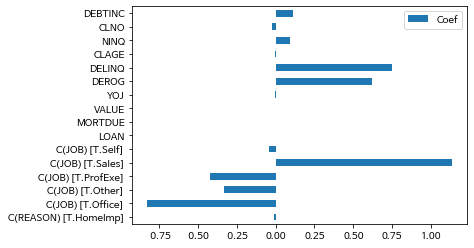

In [25]:
# 변수 중요도 확인
df_reg_scaled_coef=pd.DataFrame({"Coef":scaled_log_result.params.values[1:]},\
                         index = scaled_log_model.exog_names[1:])
df_reg_scaled_coef.plot.barh(y='Coef', legend=True)